In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import tensorflow as tf

In [2]:
img_path=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images")
anno_path=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations")
train_df = pd.read_csv('../input/face-mask-detection-dataset/train.csv')
submission = pd.read_csv('../input/face-mask-detection-dataset/submission.csv')
print(len(os.listdir(img_path)))
print(len(os.listdir(anno_path)))

6024
4326


In [3]:
images=os.listdir(img_path)
annot=os.listdir(anno_path)
images.sort()
annot.sort()

In [4]:
train_images=images[1698:]
test_images=images[:1698]

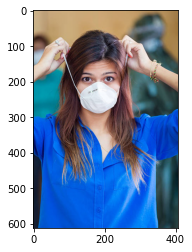

In [5]:
img=plt.imread(os.path.join(img_path,train_images[3]))
plt.imshow(img)
plt.show()

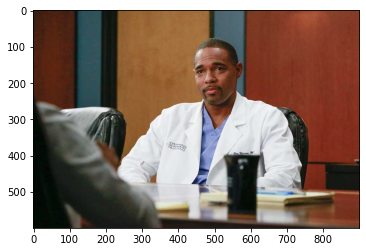

In [6]:
img=plt.imread(os.path.join(img_path,train_images[10]))
plt.imshow(img)
plt.show()

In [7]:
train_df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [8]:
label={}
for i in range(len(train_df['classname'].unique())):
      label[train_df['classname'].unique()[i]] = i

In [9]:
train_df['name'].nunique()

4326

In [10]:
train_df['classname'].nunique()

20

In [11]:
train_df['classname'].value_counts()

face_with_mask              4180
mask_surgical               2430
mask_colorful               1876
face_no_mask                1569
face_other_covering         1372
eyeglasses                   914
hat                          823
sunglasses                   358
hair_net                     287
scarf_bandana                260
goggles                      192
helmet                       187
hijab_niqab                  173
face_shield                  160
hood                         159
face_with_mask_incorrect     150
balaclava_ski_mask           134
turban                        94
gas_mask                      55
other                         39
Name: classname, dtype: int64

In [12]:
train_df['name'].value_counts().max()

37

In [13]:
box=[]
for i in range(len(train_df)):
    arr=[]
    for j in train_df.iloc[i][['x1','x2','y1','y2']]:
        arr.append(j)
    box.append(arr)
train_df['box']=box

In [14]:
def get_boxes(id):
    boxes=[]
    for i in train_df[train_df["name"]==str(id)]["box"]:
        boxes.append(i)
    return boxes

In [15]:
print(get_boxes(train_images[0]))

[[451, 186, 895, 697]]


In [16]:
train_images[571]

'2422.png'

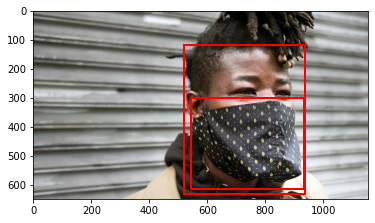

In [17]:
image = '1861.jpg'
img=plt.imread(os.path.join(img_path, image))
fig, ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

# **Train Test Split**

In [18]:
img_size=50
x=[]
y=[]
for i in range(len(train_df)):
    arr=[]
    for item in train_df.iloc[i]:
        arr.append(item)
    img = cv2.imread(os.path.join(img_path, arr[0]), cv2.IMREAD_GRAYSCALE)
    img = img[arr[2]:arr[4], arr[1]:arr[3]]
    try:
        img = cv2.resize(img, (img_size, img_size))
    except:
        continue
    x.append(img)
    y.append(arr[5])

In [19]:
y[i]==14

IndexError: list index out of range

In [20]:
labels=['face_no_mask','face_with_mask','hood','helmet','eyeglasses']

In [21]:
x_mask=[]
y_mask=[]
for i in range(len(x)):
    if y[i] in labels:
        x_mask.append(x[i])
        y_mask.append(y[i])
    elif y[i]=='mask_colorful' or y[i]=='mask_surgical':
        x_mask.append(x[i])
        y_mask.append('face_with_mask')

In [22]:
from sklearn.preprocessing import LabelEncoder
lr = LabelEncoder()
y_mask = lr.fit_transform(y_mask)

In [23]:
x_mask=np.array(x_mask).reshape(-1,50,50,1)
x_mask=tf.keras.utils.normalize(x_mask,axis=1)
from keras.utils import to_categorical
y_mask = to_categorical(y_mask)

Using TensorFlow backend.


In [24]:
!pip install livelossplot

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [25]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF

In [26]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(50,50,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 128)       5

In [27]:
epochs = 30
checkpoint = ModelCheckpoint("model_weights.h5", save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint]

history = model.fit(x_mask,y_mask,epochs=epochs,batch_size=5)

Epoch 1/30
2263/2263 [==============================] - 22s 10ms/step - loss: 0.7259 - accuracy: 0.7573
Epoch 2/30
2263/2263 [==============================] - 22s 10ms/step - loss: 0.5665 - accuracy: 0.8186
Epoch 3/30
2263/2263 [==============================] - 22s 10ms/step - loss: 0.4876 - accuracy: 0.8431
Epoch 4/30
2263/2263 [==============================] - 22s 10ms/step - loss: 0.4407 - accuracy: 0.8573
Epoch 5/30
2263/2263 [==============================] - 23s 10ms/step - loss: 0.3897 - accuracy: 0.8750
Epoch 6/30
2263/2263 [==============================] - 22s 10ms/step - loss: 0.3600 - accuracy: 0.8844
Epoch 7/30
2263/2263 [==============================] - 22s 10ms/step - loss: 0.3333 - accuracy: 0.8940
Epoch 8/30
2263/2263 [==============================] - 22s 10ms/step - loss: 0.2950 - accuracy: 0.9021
Epoch 9/30
2263/2263 [==============================] - 22s 10ms/step - loss: 0.2751 - accuracy: 0.9106
Epoch 10/30
2263/2263 [==============================] - 23s 10m

In [28]:
pip install mtcnn

     |████████████████████████████████| 2.3 MB 605 kB/s 
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [29]:
from mtcnn.mtcnn import MTCNN

In [30]:
def predict(pic):
    detector=MTCNN()
    img = plt.imread(pic)
    inp=cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
    faces = detector.detect_faces(img)
    for face in faces:
        bounding_box = face['box']
        inp = inp[bounding_box[1]:bounding_box[1]+bounding_box[3], bounding_box[0]:bounding_box[0]+bounding_box[2]]
        img=cv2.rectangle(img,(bounding_box[0], bounding_box[1]),(bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                          (0,155,255),
                          10)
        inp=cv2.resize(inp,(50,50))
        inp=inp.reshape(-1,50,50,1)
        predict=model.predict(inp)
        plt.imshow(img)
        for i in range(len(predict)):
            print(lr.inverse_transform([np.argmax(predict[i])])[0])

hood


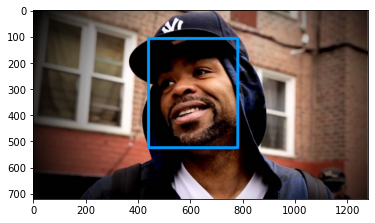

In [31]:
predict(os.path.join(img_path, test_images[0]))

In [32]:
lr.classes_

array(['eyeglasses', 'face_no_mask', 'face_with_mask', 'helmet', 'hood'],
      dtype='<U14')